# colorClusters

In [179]:
import subprocess
import numpy as np
import scipy
from skimage.color import rgb2hsv
from skimage.color import hsv2rgb
from skimage import morphology
from PIL import Image, ImageFilter
from scipy.cluster.vq import vq, kmeans, whiten
import sys
# C:\Users\jokemjaa\Documents\GitHub\jupyter\jedit
sys.path.append("C:\\users\\jokemjaa\\Documents\\github\\")
import jupyter_cell_magics.jedit as jedit
import mycolors as mc


In [151]:
const = type('globals', (object,), {})()
const.margin = 20
const.width = 80

def contrastFactor(level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    return factor

contrastFactor(300)

def imClustered(im, i, skip = 7):
    ar = np.array(im)
    ret = Image.fromarray(arClustered(ar, i, skip = skip))
    return ret

def arClustered(ar, i,skip = 7):
    shape = ar.shape
    colorData = ar.reshape((int(ar.size / 3), 3))
    codebook, distortion = kmeans(colorData[::skip].astype('float'), i) 
    code2color = lambda x: codebook.astype('uint8')[x]
    dataClustered, foo = vq(colorData, codebook)
    bar = np.apply_along_axis(code2color, 0, dataClustered)
    return bar.reshape(shape)


def genCodebook(im, i = 5, hsv = True):
    im2 = im.resize((320, 180))
    if hsv:
        ar = rgb2hsv(np.array(im2))
    else:
        ar = np.array(im2)
    colorData = ar.reshape((int(ar.size / 3), 3))
    codebook, distortion = kmeans(colorData.astype('float'), i)
    return codebook

def genDistortion(im, i = 5, hsv = True):
    im2 = im.resize((320, 180))
    if hsv:
        ar = rgb2hsv(np.array(im2))
    else:
        ar = np.array(im2)
    colorData = ar.reshape((int(ar.size / 3), 3))
    codebook, distortion = kmeans(colorData.astype('float'), i)
    return distortion


def genClustered(im, hsv = True, i = None, codebook = None, dataOnly = False):
    if codebook is None:
        codebook = genCodebook(im, i = i, hsv = hsv)
    if i is None:
        i = len(codebook)
    if hsv:
        code2color = lambda x: codebook[x]
    else:
        code2color = lambda x: codebook.astype('uint8')[x]
    ar = np.array(im)
    shape = ar.shape
    if hsv:
        colorData = rgb2hsv(ar).reshape((int(ar.size / 3), 3))
    else:
        colorData = ar.reshape((int(ar.size / 3), 3))
    dataClustered, foo = vq(colorData, codebook)
    if dataOnly:
        return dataClustered.reshape(shape[:2])
    bar = np.apply_along_axis(code2color, 0, dataClustered)
    if hsv:
        retArr = (hsv2rgb(bar.reshape(shape)) * 255).astype('uint8')
    else:
        retArr = bar.reshape(shape)
    return Image.fromarray(retArr)    
# genClustered(im, 4, hsv = True)

def removeHoles(arc):
    area_threshold = 31
    connectivity = 1
    arc = ~arc
    arc = morphology.remove_small_holes(arc, area_threshold = area_threshold, connectivity = connectivity)
    arc = ~arc
    arc = morphology.remove_small_holes(arc, area_threshold = area_threshold, connectivity = connectivity)
    return arc


(925, 1296) None


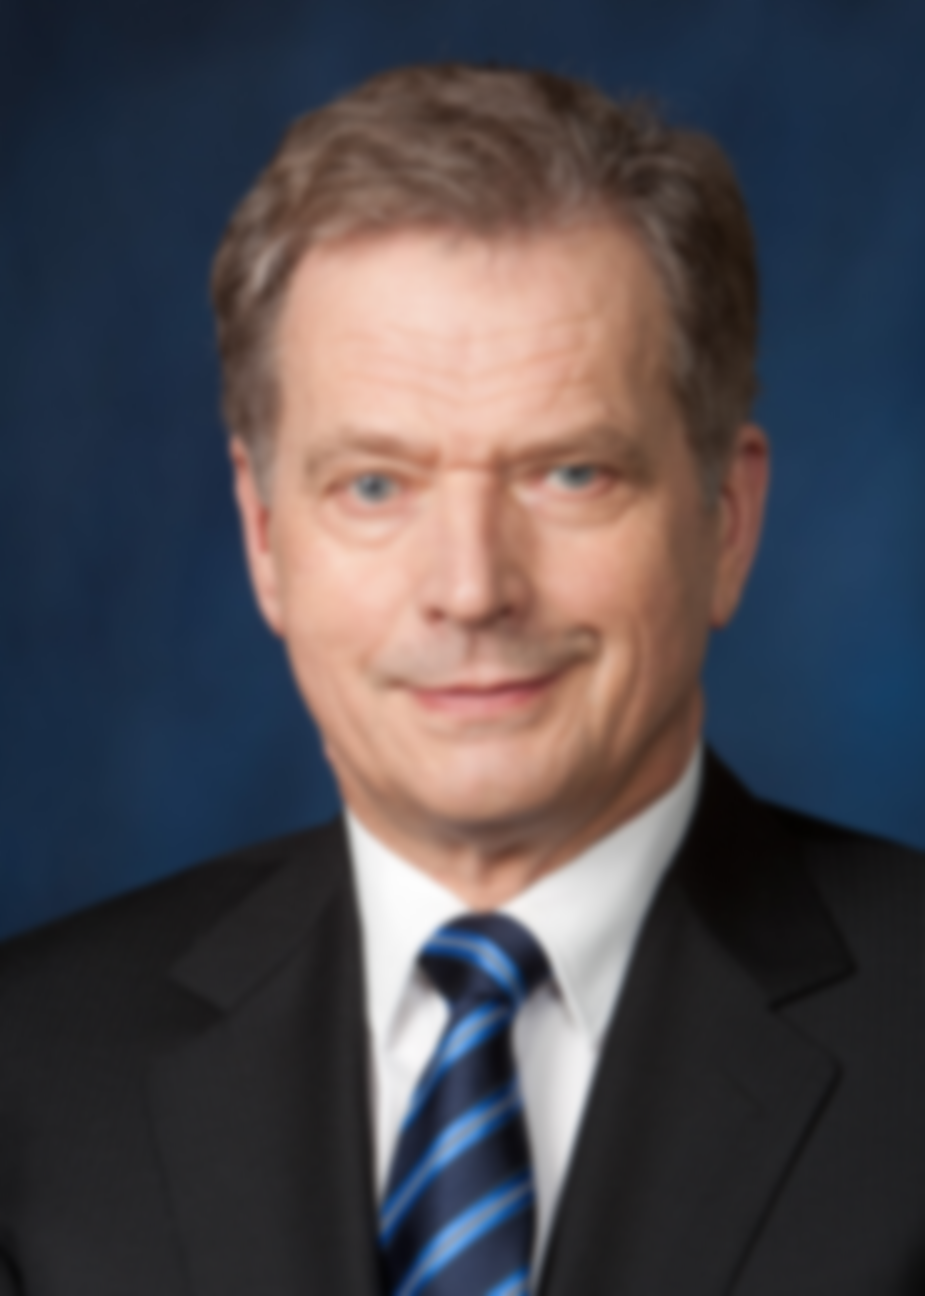

In [310]:
# imagePath = r'C:\work\img\img_0501.jpg'
imagePath = r'c:\users\jokemjaa\downloads\Sauli_Niinisto.jpg'
im = Image.open(imagePath)
# im = Image.open('G:\jokemjaaPublic\misc\mikki.jpg')
resizeFactor = 2
hsv = True
clusterCount = 6
im = im.resize((int(im.size[0] / resizeFactor), int(im.size[1] / resizeFactor)))
print(im.size, im.format)
im = im.filter(ImageFilter.GaussianBlur(radius=4))
im

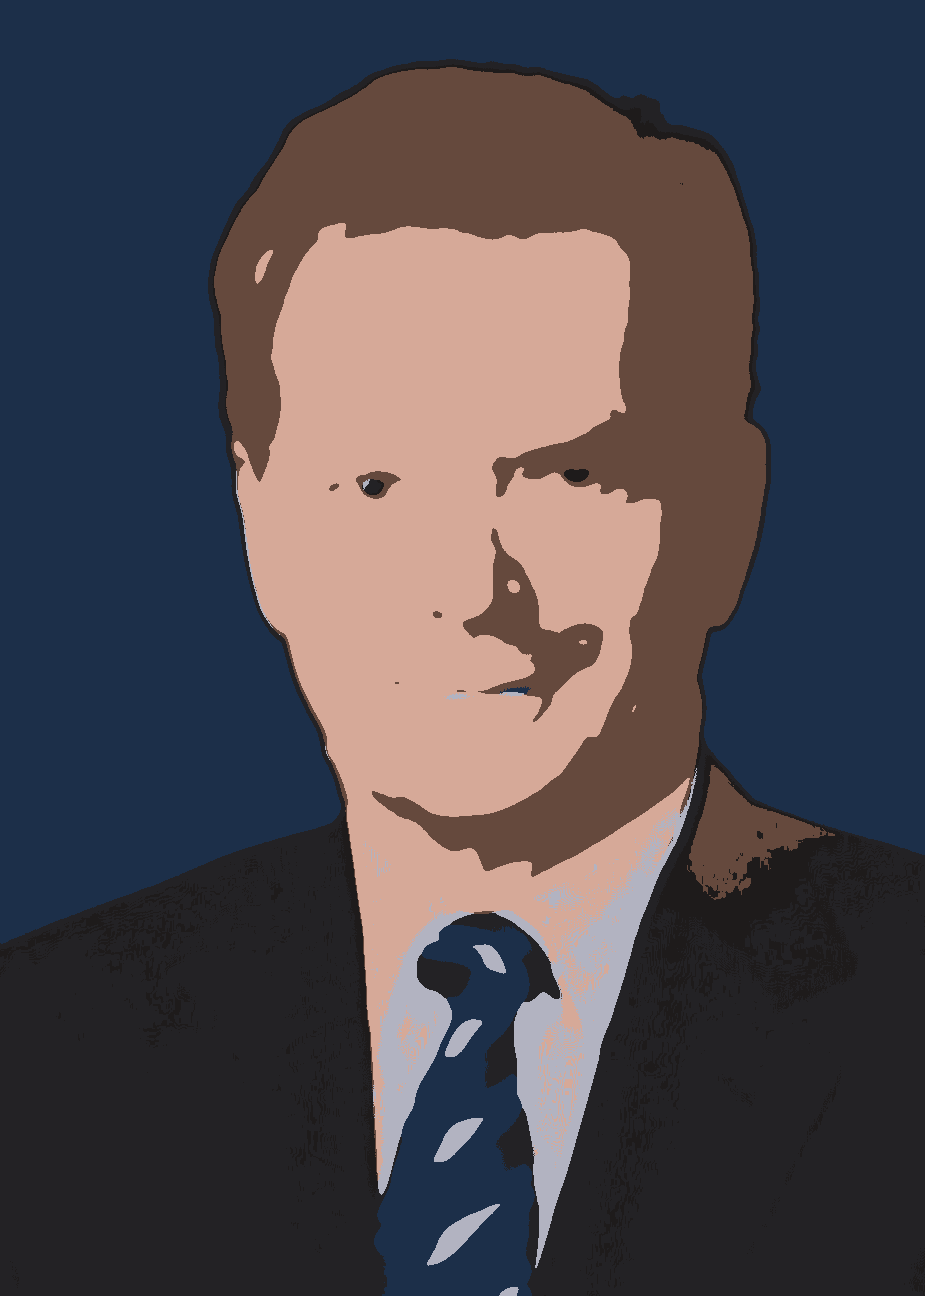

In [311]:
genClustered(im, i=clusterCount)


## Codebook

In [312]:
codebook = genCodebook(im, i=clusterCount)
print(codebook)

colors = [mc.hsv2rgb(tuple(c)) for c in codebook]

colorChart = jedit.Jedit('colorChart.html')
jedit.setGlobals(colors = colors, len = len, const = const, int = int, tuple = tuple)

# colorChart.show(colors = colors, len = len, const = const, tuple = tuple, int = int)

from IPython.core.display import HTML
HTML(colorChart.getRendered(colors = colors, len = len, const = const, tuple = tuple, int = int))


def adjust(x, p):
    return x + p * x * (1 - x)



def adjustCodebook(codebook, dhsv):
    dh, ds, dv = dhsv
    for c in codebook:
        c[0] = adjust(c[0], dh)
        c[1] = adjust(c[1], ds)
        c[2] = adjust(c[2], dv)

codebook = genCodebook(im, i=clusterCount)
adjustCodebook(codebook, (0, -0.5, 1))
colors = [mc.hsv2rgb(tuple(c)) for c in codebook]
HTML(colorChart.getRendered(colors = colors, len = len, const = const, tuple = tuple, int = int))

# 

[[0.73748531 0.06417948 0.14612291]
 [0.59481909 0.6081849  0.28761883]
 [0.0469738  0.2818117  0.8562066 ]
 [0.66208918 0.07452144 0.758449  ]
 [0.04986076 0.38966318 0.48348343]
 [0.03750093 0.26750361 0.15948154]]


## Single cluster

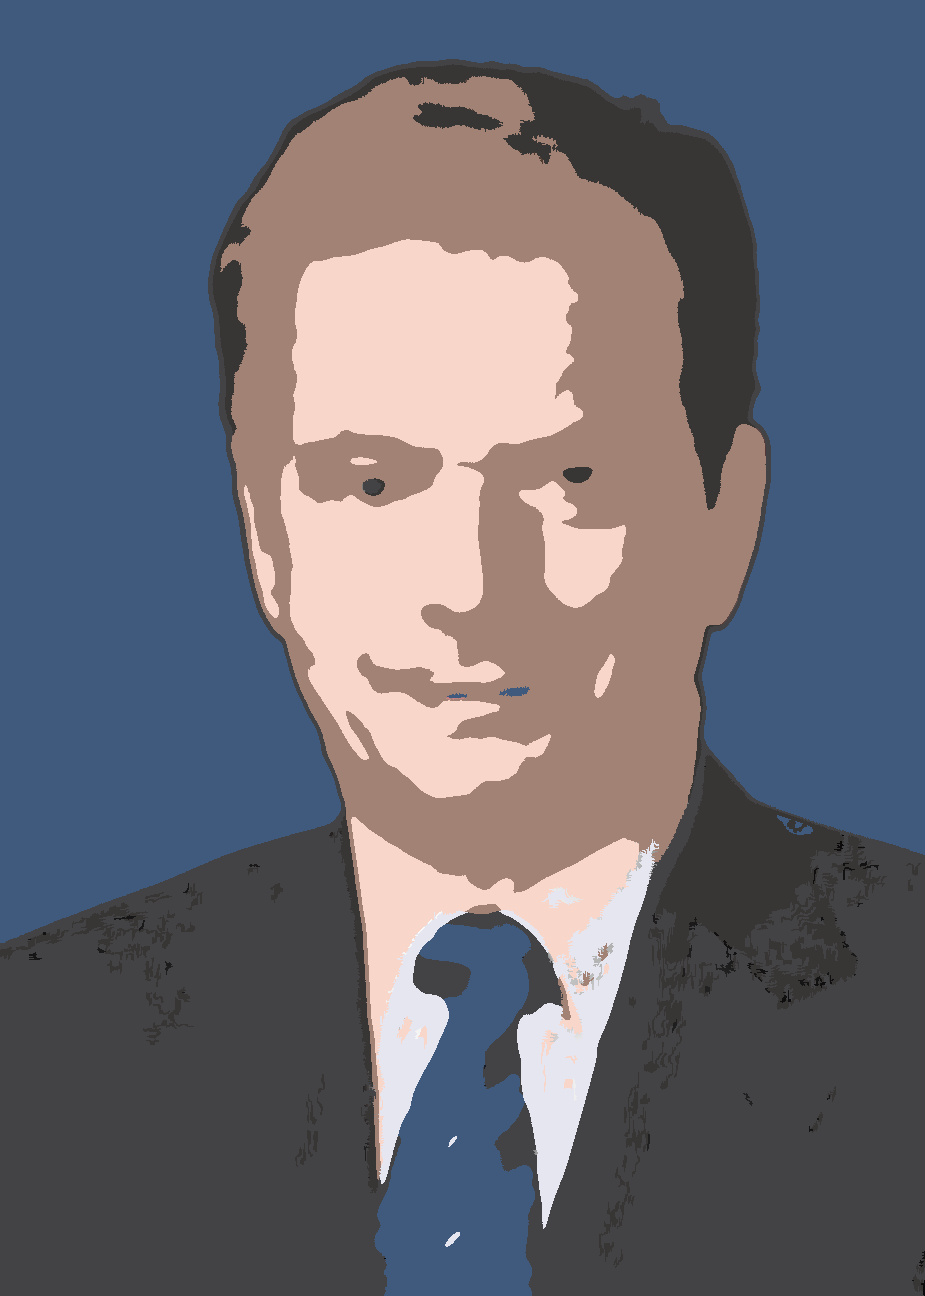

In [313]:
codebook = genCodebook(im, i=clusterCount)
adjustCodebook(codebook, (0, -0.5, 1))
colors = [mc.hsv2rgb(tuple(c)) for c in codebook]

ar = genClustered(im, codebook=codebook, dataOnly=True)
arClusters = []
for j in range(clusterCount):
    arClusters.append((ar == j))

arClustersFinal = [removeHoles(arc) for arc in arClusters]
arFinal = np.array(im)

for i in range(clusterCount):
    arFinal[arClustersFinal[i]] = colors[i]
Image.fromarray(arFinal)

In [ ]:
# for arc in arClusters:
#     display(Image.fromarray(arc))
# arFinal.shape
# for i in range(clusterCount):
#     arFinal[~arClustersFinal[i]] = 255 - colors[i]


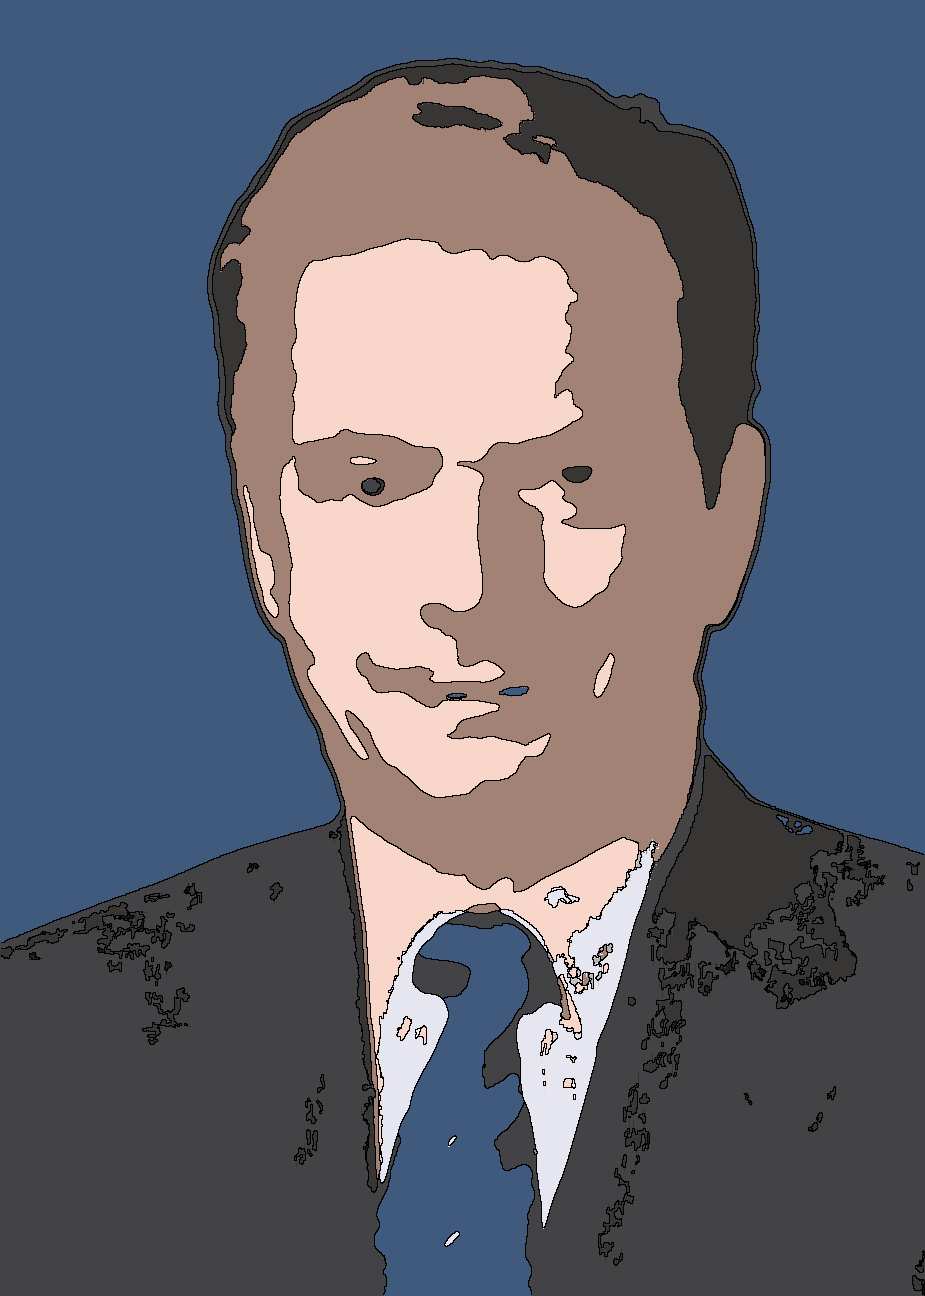

In [314]:
from skimage import filters
import scipy

arf = None
for arc in arClusters:
    ar2 = filters.gaussian(removeHoles(arc), sigma = 1) > 0.5
    
#     display(Image.fromarray(ar2))
#     display(Image.fromarray(removeHoles(arc)))
    if arf is None:
        arf = filters.roberts(ar2)
    else:
        arf += filters.roberts(ar2)

# display(Image.fromarray(arf > 0.1))
arFinal[arf > 0] = (0, 0, 0)
Image.fromarray(arFinal)

In [161]:
Image.fromarray(filters.roberts(np.array(im)[:,:,0]))

OSError: cannot write mode F as PNG

<PIL.Image.Image image mode=F size=249x444 at 0x289A4680108>

## Sivu

Näytetään html-sivulla eri klusterimäärien vaikutus

In [26]:
%%jedit -w clusters.css -t clusters.html -o temp.html
<style>

body {
  margin: 0;
  font-family: Arial;
  font-size: 17px;
    
}

img {
  padding: 70px;
//  border: 1px solid #4CAF50;
  left: 10%;
//  top: 50%;
%%  transform: translate(-50%, -50%);
}

</style>


Opening page file:///C:\Users\jokemjaa\Google Drive\python\Jupyter\notebooks\Art\stillVideos\templates/temp.html in the browser


In [69]:
hsv = True
maxClusters = 12

for i in range(2, maxClusters):
    print(i)
    out = genClustered(im, i, hsv = hsv)
#     display(out)
    out.save(f"C:/work/temp/img_{i}.png")

2
3
4
5
6
7
8
9
10
11


In [42]:
colorChart = jedit.Jedit('colorChart.html')

# colors = [list(c.astype('uint8')) for c in kmeans.cluster_centers_]
colors = [mc.hsv2rgb(tuple(c)) for c in kmeans.cluster_centers_]
# colorChart.show(colors = colors, len = len, const = const, tuple = tuple, int = int)




const = type('globals', (object,), {})()
const.margin = 20
const.width = 80

jedit.setGlobals(colors = colors, len = len, const = const, int = int, tuple = tuple)

colorChart.show(colors = colors, len = len, const = const, tuple = tuple, int = int)

from IPython.core.display import HTML
HTML(colorChart.getRendered(colors = colors, len = len, const = const, tuple = tuple, int = int))

%%jedit -h -w colorChart.html
<svg width="1000" height="1000">
{% for i in range(len(colors)) %}
  <rect width="{{ const.width }}" height="{{ const.width }}" 
    x="{{ (const.width + const.margin) * (i % 10) }}" 
    y="{{ (const.width + const.margin) * int(i / 10) }}"
    style="fill:rgb{{ tuple(colors[i]) }}" 
    />
{% endfor %}

</svg>

In [18]:
%%jedit -h -w colorChart.html
<svg width="1000" height="{{ const.width * (1 + int(len(colors) / 10)) }}">
{% for i in range(len(colors)) %}
  <rect width="{{ const.width }}" height="{{ const.width }}" 
    x="{{ (const.width + const.margin) * (i % 10) }}" 
    y="{{ (const.width + const.margin) * int(i / 10) }}"
    style="fill:rgb{{ tuple(colors[i]) }}" 
    />
{% endfor %}


</svg>

In [70]:
%%jedit -w clusters.html -o temp.html
{% include "clusters.css" %}
{% for i in range(2, 12) %}
<h2>{{ i }} clusters</h2>
<img
  src = "file:///C:/work/temp/img_{{ i }}.png"
>
{% endfor %}

Opening page file:///C:\Users\jokemjaa\Google Drive\python\Jupyter\notebooks\Art\stillVideos\templates/temp.html in the browser
